In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from qiskit import Aer, QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.opflow import Z, I, StateFn, PauliSumOp, AerPauliExpectation, ListOp, Gradient, PauliExpectation
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import  ZZFeatureMap, MCMT, RYGate
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit.circuit.library.standard_gates import HGate

from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN, OpflowQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR

from typing import Union

from qiskit_machine_learning.exceptions import QiskitMachineLearningError

from IPython.display import clear_output

from sklearn.model_selection import train_test_split

algorithm_globals.random_seed = 42
hamiltonian = Z ^ I^ I
#hamiltonian_TTN = I ^ Z^ I ^ I
#hamiltonianRed = Z ^ I ^ I

from auxData import Load_Data, Load_DataFull, plot_sampled_data_sepal, plot_predicted
from auxQuantum import FeatureMap, Neuron, TTN, FeatureMapFull, WeightlessNN
from mlxtend.plotting import plot_decision_regions


In [2]:
# Loading some example data
iris = datasets.load_iris()
X = iris.data[:, [0, 1]]
Y = iris.target
X = np.array(X[:100])
Y = np.array(Y[:100])

# Randomly shuffle data and labels 
rnd = np.random.RandomState(42)
idx = rnd.permutation(len(Y))
X, Y = X[idx], Y[idx]

# Scale to the range (0, +1)
y01 = (Y - min(Y))
y01 = y01 // max(y01)

# Scale to the range (-1, +1)
minmax_scale = MinMaxScaler((-1, 1)).fit(X)
X = minmax_scale.transform(X)
y = 2 * y01 -1




In [3]:
y

array([ 1,  1,  1, -1, -1, -1, -1,  1, -1, -1, -1, -1,  1, -1,  1, -1,  1,
        1, -1, -1,  1,  1, -1, -1,  1, -1, -1,  1, -1,  1, -1, -1,  1, -1,
        1, -1,  1,  1, -1, -1, -1, -1, -1,  1, -1, -1,  1, -1,  1, -1, -1,
       -1, -1, -1, -1,  1, -1,  1, -1,  1,  1,  1,  1, -1,  1,  1, -1,  1,
        1,  1,  1, -1,  1, -1,  1,  1,  1, -1,  1,  1,  1,  1, -1, -1, -1,
        1, -1, -1, -1,  1,  1,  1,  1,  1, -1,  1,  1, -1,  1,  1],
      dtype=int32)

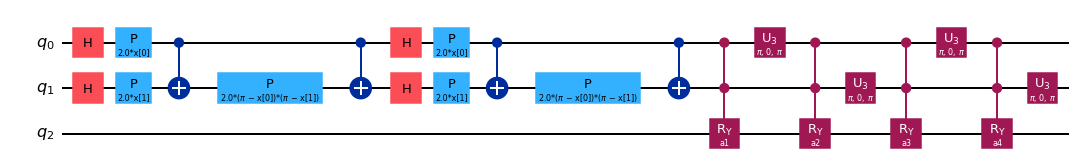

In [31]:
test = QuantumCircuit(3)
#feature_map = FeatureMap()
feature_map = ZZFeatureMap(2)
test.append(feature_map, [0,1])
ansatz=Neuron("a1", "a2", "a3", "a4")
test.append(ansatz, [0,1,2])
test.decompose().decompose().draw('mpl', style='iqx')

In [32]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [33]:
from qiskit.algorithms.optimizers import GradientDescent
quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator"), shots=1024)
gd_qnn_loss = []
def gd_qnn_callback(*args):
    gd_qnn_loss.append(args[2])

qnn_expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(test)

qnn = OpflowQNN(qnn_expectation, 
                input_params=list(feature_map.parameters), 
                weight_params=list(ansatz.parameters),
                exp_val=PauliExpectation(),
                gradient=Gradient(),  
                quantum_instance=quantum_instance)

In [34]:
opflow_classifier = NeuralNetworkClassifier(qnn, optimizer=COBYLA(), callback=callback_graph)


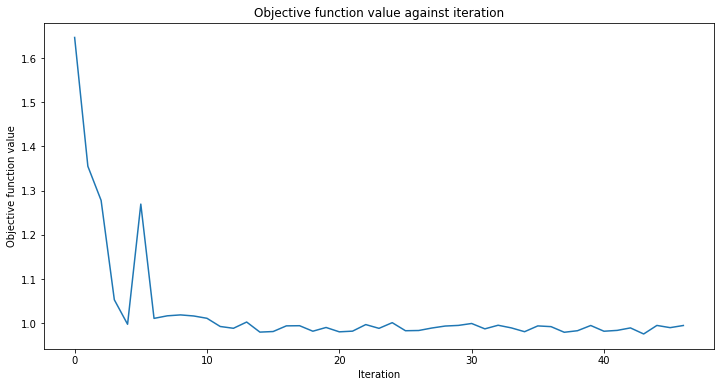

0.59

In [35]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
opflow_classifier.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
opflow_classifier.score(X, y)

Obs: mesmo fixando o ponto inicial, a performance varia

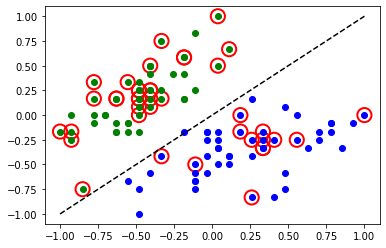

In [36]:
# evaluate data points
y_predict = opflow_classifier.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if not np.all(y_target == y_p):
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [-1, 1], "--", color="black")
plt.show()

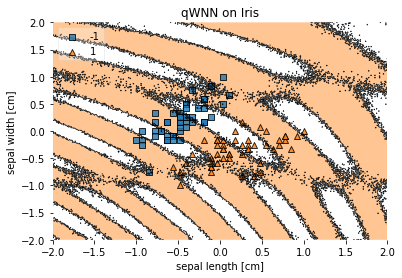

In [37]:
from mlxtend.plotting import plot_decision_regions
# Plotting decision regions
# Plotting decision regions
plot_decision_regions(X, y, clf=opflow_classifier, legend=2)

# Adding axes annotations
plt.xlabel('sepal length [cm]')
plt.ylabel('sepal width [cm]')
plt.title('qWNN on Iris')
plt.show()

In [39]:
test2_col1 = np.random.uniform(low=-1.0, high=1.0, size=(500,))
test2_col2 = np.random.uniform(low=-1.0, high=1.0, size=(500,))
test2= np.vstack((test2_col2, test2_col1)).T

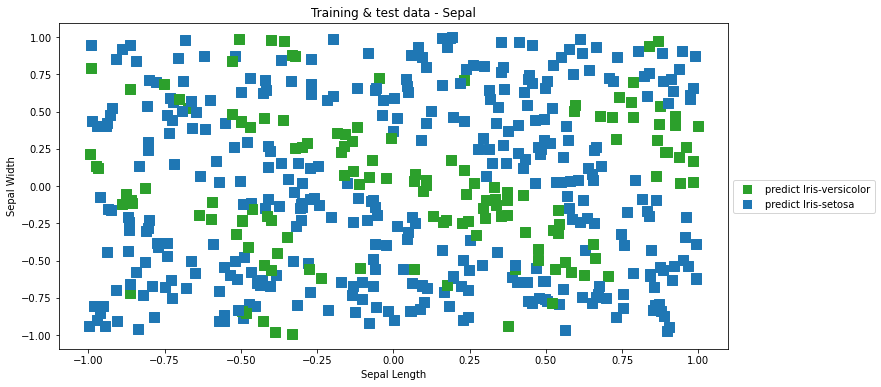

In [40]:
predicted = opflow_classifier.predict(test2)
def plot_area(a,b, test_features):
    from matplotlib.lines import Line2D
    wrong_predicted = 0
    plt.figure(figsize=(12, 6))
    label_train = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
    label_test = ['predict Iris-setosa', 'predict Iris-versicolor', 'predict Iris-virginica']
    
    for feature, pred in zip(test_features, predicted):
        marker = 's' 
        color = 'tab:green' if pred == -1 else 'tab:blue'
        plt.scatter(feature[0], feature[1], marker=marker, s=100, color=color)
    
    legend_elements = [

        Line2D([0], [0], marker='s', c='w', mfc='tab:green', label=label_test[b-1], ms=10),
        Line2D([0], [0], marker='s', c='w', mfc='tab:blue', label=label_test[a-1], ms=10),

    ]

    plt.legend(loc= "lower left", handles=legend_elements, bbox_to_anchor=(1.0, 0.4))
    plt.title('Training & test data - Sepal')
    plt.xlabel('Sepal Length')
    plt.ylabel('Sepal Width')
plot_area(1,2, test2)